<a href="https://colab.research.google.com/github/elliehaber/icd_code_pred/blob/master/The_Final_Baseline5_25_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import io
import numpy as np
from matplotlib import pyplot as plt 

In [0]:
import torch
print(torch.__version__)


1.5.0+cu101


In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#patient notes data
df_notes = pd.read_csv('NOTEEVENTS.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#icd diagnoses data
df_icd_diag = pd.read_csv('DIAGNOSES_ICD 2.csv')

106379
['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081']


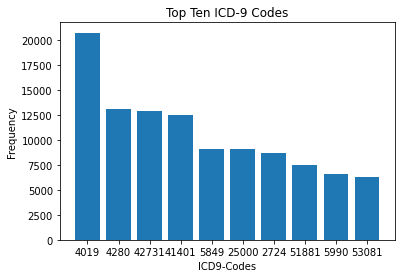

In [0]:
#Identify the top 10 occurring ICD-9 Codes
import matplotlib.pyplot as plt

df_icd_diag.head()
freq = df_icd_diag['ICD9_CODE'].value_counts()[:10].index.tolist()
x = df_icd_diag['ICD9_CODE'].value_counts()[:50].index.tolist()


print(sum(df_icd_diag['ICD9_CODE'].value_counts()[:10]))
freq_val = df_icd_diag['ICD9_CODE'].value_counts()[:10]
plt.bar(freq, freq_val)
plt.title('Top Ten ICD-9 Codes')
plt.ylabel('Frequency')
plt.xlabel('ICD9-Codes')

print(freq)

In [0]:
#Filter for notes with discharge summary
df_notes_discharge_summ = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [0]:
df_notes_discharge_summ_last = (df_notes_discharge_summ.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()
assert df_notes_discharge_summ_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [0]:
df_icd_notes = pd.merge(df_icd_diag[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']], \
df_notes_discharge_summ_last[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on= ['SUBJECT_ID', 'HADM_ID'], how = 'left'
)

assert len(df_icd_diag) == len(df_icd_notes), 'Number of rows increased'

In [0]:
#filter for first admission
df_icd_notes_1 = df_icd_notes[df_icd_notes.ICD9_CODE.isin(x)]
print(len(df_icd_notes_1))
df_icd_notes = df_icd_notes[df_icd_notes.ICD9_CODE.isin(freq)]
df_icd_notes_1 = df_icd_notes[df_icd_notes.ICD9_CODE.isin(x)]

t = df_icd_notes.drop_duplicates(subset='HADM_ID', keep="first", inplace=True)
df_icd_notes = df_icd_notes.dropna(how='any',subset=['TEXT'])

len(df_icd_notes)

242728


40562

In [0]:
#Extract Hospital Course section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'concise summary of hospital course as follows:' in i:
    start = i.find('concise summary of hospital course as follows:') 
    lst.append(i[start+46:])
  elif 'hospital course:' in i:
    start = i.find('hospital course:') 
    lst.append(i[start+16:])
  else: 
    lst.append('not valid')

df_icd_notes['Hosp_course'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.Hosp_course != 'not valid']


In [0]:
#Extract History of Present Illness section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'history of present illness' in i:
    start = i.find('history of present illness:')
    lst.append(i[start+27:])
  else:
    lst.append('not valid')


df_icd_notes['hist_pres_illness'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.hist_pres_illness != 'not valid']


In [0]:
df_icd_notes = df_icd_notes.dropna(how='any',subset=['Hosp_course'])
df_icd_notes = df_icd_notes.dropna(how='any',subset=['hist_pres_illness'])


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 5.9MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [0]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
import string


def preprocess(text):  
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ""))
    text = text.lower().translate(t)
    text = text.replace('\n','')
    return text

In [0]:

# labels_dict = {}
# num = 0
# for i in freq:
#   labels_dict[str(i)] = num
#   num+= 1

# print(labels_dict)
class2idx = {
    '4019': 0,
    '4280': 1,
    '42731': 2,
    '41401': 3,
    '5849': 4,
    '25000': 5,
    '2724': 6,
    '51881': 7,
    '5990': 8,
    '53081': 9
}

# class2idx = {
#     4019: 0,
#     4280: 1,
#     42731: 2,
#     41401: 3,
#     5849: 4,
#     25000: 5,
#     2724: 6,
#     51881: 7,
#     5990: 8,
#     53081: 9
# }

idx2class = {v: k for k, v in class2idx.items()}


df_icd_notes['ICD9_CODE'].replace(class2idx, inplace=True)



In [0]:
df_icd_notes

In [0]:
labels = df_icd_notes.ICD9_CODE.values
labels = labels.astype(np.long)

sentences_hosp = df_icd_notes.TEXT.values
sentences_hosp = sentences_hosp.astype('str')

test_labels = labels[27001:30202]
test_sent = sentences_hosp[27001:30202]

for i in range(len(test_sent)):
    sent = test_sent[i]
    sent = preprocess(sent)
    test_sent[i] = sent
    
# sentences_hist = df_icd_notes.hist_pres_illness.values
# sentences_hist = sentences_hist.astype(np.string_)
# sentences = df_icd_notes.TEXT.values
# sentences = sentences.astype(np.string_)


labels = labels[:27000]
sentences_hosp = sentences_hosp[:27000]

for i in range(len(sentences_hosp)):
    sent = sentences_hosp[i]
    sent = preprocess(sent)
    sentences_hosp[i] = sent


In [0]:
!pip install transformers

     |████████████████████████████████| 665kB 2.8MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
     |████████████████████████████████| 1.1MB 41.0MB/s 
     |████████████████████████████████| 3.8MB 29.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1d9810c991253a544b33770c6e497522bace0e679711b4f5ce0516fe9dfd46cc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

from transformers import BertTokenizer

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# For every sentence...
for sent in sentences_hosp:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences_hosp[0])
print('Token IDs:', input_ids[0])

100%|██████████| 231508/231508 [00:00<00:00, 4310583.32B/s]



Token IDs: tensor([  101,  9634,  3058, 11889,  3058,  2326, 24158,  7062,  1997,  2556,
         7355,  1996,  5776,  2003,  1037,  2287,  2058,  2095, 11614,  2158,
        24415,  1037,  2381,  1997, 27233,  4588, 17359, 17119,  4295, 21887,
         2854, 16749, 10521, 19500,  3570,  2695,  2026, 24755, 25070,  1999,
        14971,  7542,  1999,  2004,  2092,  2004, 15850, 16185, 14778,  2483,
         2040,  3591,  2007, 11463, 26474,  1998,  8376,  2102,  3255,  1996,
         5776,  2988, 11463,  6761,  4588, 14708,  2015,  2335,  2144,  7610,
         2006,  1996,  2154,  3188,  2000,  9634,  2053, 19610,  3686,  7834,
         2483,  2030, 28433,  3406,  5403, 12871, 14708,  2015,  2020,  6065,
         1996,  5776,  2018,  1037,  2381,  1997, 10199,  8189,  1999,  1996,
         5776,  2036,  2988,  2108,  7138,  4974,  2098, 16342,  2094,  2007,
         2019,  3623,  1999,  2010, 10381,  2275, 10521,  9006, 13028,  2005,
         2029,  2002,  2001,  2635,  4942,  2989,  8

In [0]:
# # Create attention masks
# attention_masks = []

# # Create a mask of 1s for each token followed by 0s for padding
# for seq in input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 12

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
torch.cuda.empty_cache()

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=10)
model.cuda()

100%|██████████| 407873900/407873900 [00:07<00:00, 57471328.21B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}
]



In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=1e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
from sklearn.metrics import f1_score
errors = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}
total = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    ##determine frequent errors
    for i in range(len(pred_flat)):
      if labels_flat[i] != pred_flat[i]:
        errors[str(labels_flat[i])] += 1
      total[str(labels_flat[i])] += 1
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize


def aucscore(labels, preds):
  # print(preds)
  pred_flat = np.max(preds, axis=1).flatten()
  print(pred_flat)
  labels_flat = labels
  print('x')
  micro = roc_auc_score(labels_flat, pred_flat, average='micro', multi_class='ovo')
  print('x')
  macro = roc_auc_score(labels_flat, pred_flat, average='macro', multi_class='ovo')
  weighted = roc_auc_score(labels_flat, pred_flat, average='weighted', multi_class='ovo')

  return micro, macro, weighted

In [0]:
def f1score(labels, preds):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  micro = f1_score(labels_flat, pred_flat, average='micro')
  macro = f1_score(labels_flat, pred_flat, average='macro')
  weighted = f1_score(labels_flat, pred_flat, average='weighted')

  return micro, macro, weighted


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
from sklearn.metrics import f1_score

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  total_eval_loss=0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass

    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  f1_micr, f1_macr, f1_weight = 0,0,0
  auc_micr, auc_macr, auc_weight = 0,0,0
  nb_eval_steps, nb_eval_examples = 0, 0
 
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    total_eval_loss+= loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)
    #tmp_auc_micr, tmp_auc_macr, tmp_auc_weight = aucscore(label_ids, logits)
    eval_accuracy += tmp_eval_accuracy

    #calculate f1 scores
    f1_micr += tmp_f1_micr
    f1_macr += tmp_f1_macr
    f1_weight += tmp_f1_weight

    # #calculate auc
    # auc_micr += tmp_auc_micr
    # auc_macr += tmp_auc_macr
    # auc_weight += tmp_auc_weight

    nb_eval_steps += 1
  print('TOTAL EVAL LOSS: ', total_eval_loss/len(validation_dataloader))
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  print('F1 micro:', f1_micr/nb_eval_steps)  
  print('F1 macro:', f1_macr/nb_eval_steps)
  print('F1 weight:', f1_weight/nb_eval_steps)
  print('    DONE.')
  #print('AUC macro: ', auc_macr/nb_eval_steps )

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 1.8843485074573092


Epoch:  25%|██▌       | 1/4 [28:54<1:26:44, 1734.96s/it]

TOTAL EVAL LOSS:  1.6018424034118652
Validation Accuracy: 0.45037037037037003
F1 micro: 0.45037037037037003
F1 macro: 0.3288580712644204
F1 weight: 0.41982202982203004
    DONE.
Train loss: 1.614290347982336


Epoch:  50%|█████     | 2/4 [57:51<57:50, 1735.50s/it]  

TOTAL EVAL LOSS:  1.3884776830673218
Validation Accuracy: 0.46925925925925904
F1 micro: 0.46925925925925904
F1 macro: 0.35422499510092126
F1 weight: 0.4441807492918605
    DONE.
Train loss: 1.520292144410404


Epoch:  75%|███████▌  | 3/4 [1:26:47<28:55, 1735.73s/it]

TOTAL EVAL LOSS:  1.369158387184143
Validation Accuracy: 0.48333333333333345
F1 micro: 0.48333333333333345
F1 macro: 0.3664672576101148
F1 weight: 0.45774790230345797
    DONE.
Train loss: 1.4331650678463923


Epoch: 100%|██████████| 4/4 [1:55:43<00:00, 1735.91s/it]

TOTAL EVAL LOSS:  1.700575351715088
Validation Accuracy: 0.48111111111111116
F1 micro: 0.48111111111111116
F1 macro: 0.36416629459116223
F1 weight: 0.45533119555341806
    DONE.


In [0]:
errors


{'0': 668,
 '1': 927,
 '2': 586,
 '3': 256,
 '4': 812,
 '5': 421,
 '6': 224,
 '7': 633,
 '8': 894,
 '9': 292}

In [0]:
total

{'0': 1432,
 '1': 1508,
 '2': 1116,
 '3': 1716,
 '4': 1464,
 '5': 432,
 '6': 224,
 '7': 1588,
 '8': 988,
 '9': 332}

In [0]:
import os
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model


print("Saving model to %s" % output_dir)
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_pretrained(output_dir)
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sent:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sent[0])
print('Token IDs:', input_ids[0])

Token IDs: tensor([  101,  9634,  3058, 11889,  3058,  3058,  1997,  4182,  3348,  5796,
         2121,  7903,  2063,  4003, 25185, 16977, 19053, 24164, 10623,  3111,
         3286,  4135,  4305, 19265, 19321, 18537,  8873, 12096,  2171,  1048,
         2546,  2708, 12087,  5149, 13102, 22084,  2006,  4654,  8743,  3258,
         3279,  1997,  8298,  2863,  5558,  2099, 11707,  2030, 17503,  7709,
        20118, 28228,  2278, 10764,  6110,  3461,  2358,  3287,  2034,  2171,
         4895,  8680, 10514, 18098, 22684, 26788,  2854, 16749, 11826, 22160,
         2102,  1060,  2187,  4722,  5003, 14760,  2854, 16749,  3406,  2187,
        15099, 15127, 20066, 10222,  3560, 12818, 22160,  2102,  2000,  1052,
        19279,  8557,  7849, 24965, 20066, 10222,  3560, 12818, 22160,  2102,
         2000, 15219, 15127, 16749, 24158,  7062,  1997,  2556,  7355, 15222,
         2015,  2095,  2214,  2158,  3653,  7361, 20118, 28228,  2278, 10764,
         6110,  2005, 16173, 12650,  1998, 21887,  28

In [0]:
test_inputs, _, test_labels, _ = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
test_masks, _, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)

batch_size = 8

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [0]:
#Test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

#initialize vars
f1_micr_test = 0
f1_macr_test = 0
f1_weight_test = 0
nb_eval_steps_test = 0

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  # predictions.append(logits)
  # true_labels.append(label_ids)

  tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)

  #calculate f1 scores
  f1_micr_test += tmp_f1_micr
  f1_macr_test += tmp_f1_macr
  f1_weight_test += tmp_f1_weight
  nb_eval_steps_test += 1

print('F1 micro test: ', f1_micr_test/nb_eval_steps_test)
print('F1 macro test: ', f1_macr_test/nb_eval_steps_test)
print('F1 weight test: ', f1_weight_test/nb_eval_steps_test)
print('    DONE.')

Predicting labels for 3,201 test sentences...
F1 micro test:  0.4600694444444444
F1 macro test:  0.33274838855295197
F1 weight test:  0.4416721781305114
    DONE.
